# 

## Import statements

In [1]:
import pandas as pd
from astropy.units import Quantity, def_unit, Unit

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

from common import xcs3p_colour, xcs_cosmo
import xga
xga.NUM_CORES = 10
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.imagetools.misc import physical_rad_to_pix
from xga.utils import r500 as r500_unit
from xga.imagetools.psf import rl_psf
from xga.sourcetools.deproj import shell_ann_vol_intersect
from xga.products.profile import GasTemperature3D, HydrostaticMass
from xga.sourcetools.density import inv_abel_fitted_model
from xga.sas.phot import emosaic

## 

In [2]:
chosen_names = ['SDSSXCS-55', 'SDSSXCS-6955']

In [3]:
xcs3p = pd.read_csv("../sample_files/xcs3p_sdssrm_clusters.csv")
example_clusters = xcs3p[xcs3p['name'].isin(chosen_names)]

example_clusters = example_clusters.reset_index(drop=True).reindex([1, 0])

In [4]:
example_clusters

name  MEM_MATCH_ID    xapa_ra   xapa_dec         z         r500  \
1    SDSSXCS-55            55  227.55039  33.516138  0.119238  1237.593143   
0  SDSSXCS-6955          6955   36.45483  -5.894148  0.222771   668.993676   

       r500-      r500+   Tx_500   Tx_500-  ...  Tx_2500+  Lx52_2500  \
1  20.055540  20.054394  6.69605  0.079980  ...  0.101421   1.991847   
0  47.899035  61.950664  2.41024  0.299063  ...  0.378930   0.164712   

   Lx52_2500-  Lx52_2500+   Lx_2500  Lx_2500-  Lx_2500+   richness  \
1    0.006548    0.006021  8.078845  0.060747  0.065648  99.802250   
0    0.006302    0.006789  0.438139  0.029802  0.033406  32.131187   

   richness_err                   XCS_NAME  
1      3.735475  XMMXCS J151012.0+333058.0  
0      2.832087  XMMXCS J022549.1-055338.9  

[2 rows x 32 columns]

In [5]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = example_clusters['xapa_ra'].values
dec = example_clusters['xapa_dec'].values
z = example_clusters['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = example_clusters['name'].values
# In kpc
r500 = Quantity(example_clusters['r500'].values, 'kpc')
r2500 = Quantity(example_clusters['r2500'].values, 'kpc')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = example_clusters['richness'].values
r_err = example_clusters['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
examp_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, richness=r, richness_err=r_err, 
                           cosmology=xcs_cosmo, load_fits=True, use_peak=False, clean_obs=True, 
                           clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|███████████████████████████████████████████████| 2/2 [00:09<00:00,  4.72s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:308: UserWarning: SDSSXCS-55 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0149880101/0149880101_pn_SDSSXCS-55_ra227.55039_dec33.516138_ri0.08579161500459656_ro0.09183327803308927_grpTrue_mincnt5_ident85228453_14_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  self._existing_xga_products(load_fits)


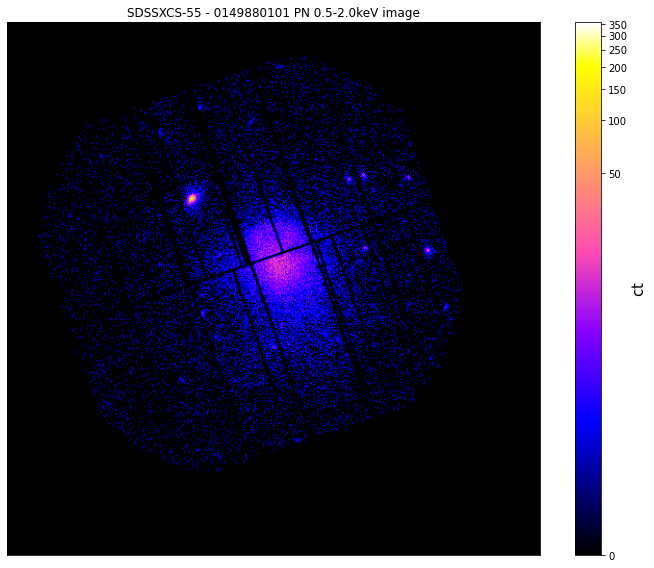

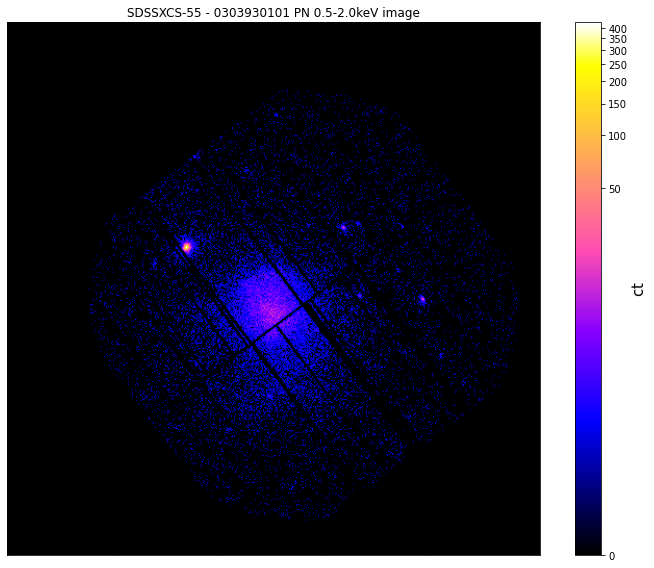

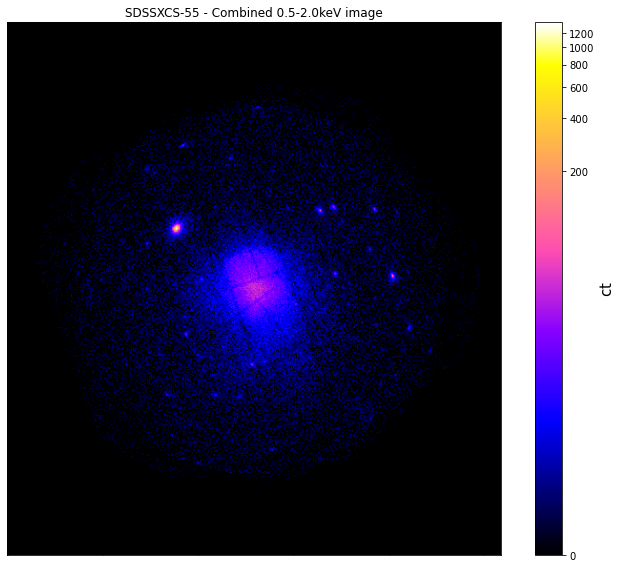

In [6]:
no_cust_reg_src = GalaxyCluster(ra[0], dec[0], z[0], n[0], r500=r500[0], r2500=r2500[0], richness=r[0], 
                                richness_err=r_err[0], cosmology=xcs_cosmo, load_fits=True, use_peak=False, 
                                clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

no_cust_reg_src._interloper_regions = [r for r in no_cust_reg_src._interloper_regions if r.visual['color'] != 'white']
no_cust_reg_src._other_regions['0149880101'] = [r for r in no_cust_reg_src.get_interloper_regions()['0149880101'] if r.visual['color'] != 'white']
no_cust_reg_src._other_regions['0303930101'] = [r for r in no_cust_reg_src.get_interloper_regions()['0303930101'] if r.visual['color'] != 'white']


im = no_cust_reg_src.get_images('0149880101', 'pn')[0]
im.view()
no_cust_reg_src._interloper_masks['0149880101'] = no_cust_reg_src._generate_interloper_mask(im)

im = no_cust_reg_src.get_images('0303930101', 'pn')[0]
im.view()
no_cust_reg_src._interloper_masks['0303930101'] = no_cust_reg_src._generate_interloper_mask(im)

im = no_cust_reg_src.get_combined_images(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
im.view()
no_cust_reg_src._interloper_masks['combined'] = no_cust_reg_src._generate_interloper_mask(im)

In [7]:
examp_srcs.info()


-----------------------------------------------------
Number of Sources - 2
Redshift Information - True
Sources with ≥1 detection - 2 [100%]
-----------------------------------------------------



In [8]:
print(examp_srcs.names)
print(examp_srcs.r500)
print(examp_srcs.r2500)

['SDSSXCS-55' 'SDSSXCS-6955']
[1237.5931434   668.99367644] kpc
[562.30738447 321.88893067] kpc


In [9]:
examp_srcs[0].r500

<Quantity 1237.5931434 kpc>

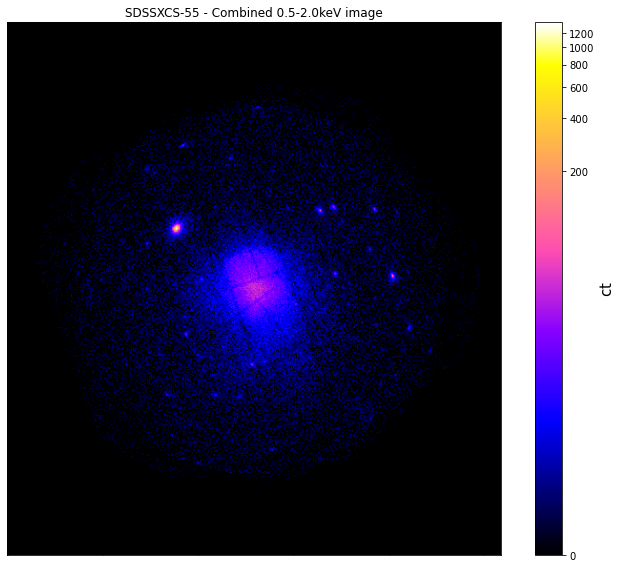

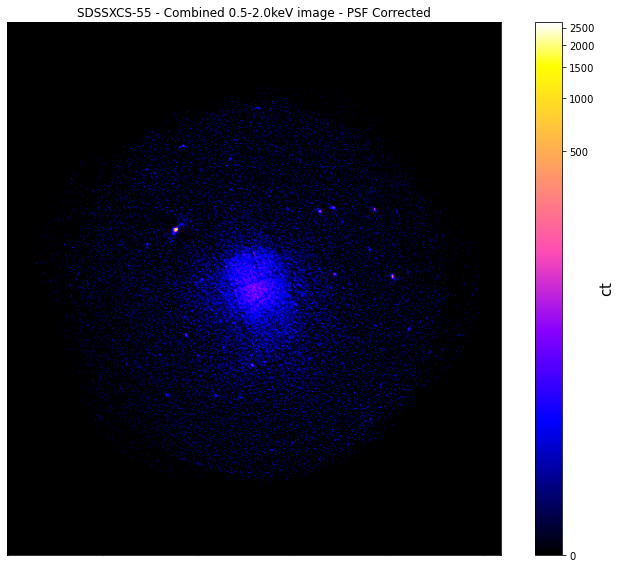


-----------------------------------------------------
Source Name - SDSSXCS-55
User Coordinates - (227.55039, 33.516138) degrees
X-ray Peak - (227.55039, 33.516138) degrees
nH - 0.0149 1e+22 / cm2
Redshift - 0.119
XMM ObsIDs - 2
PN Observations - 2
MOS1 Observations - 2
MOS2 Observations - 2
On-Axis - 2
With regions - 2
Total regions - 68
Obs with 1 detection - 2
Obs with >1 matches - 0
Images associated - 36
Exposure maps associated - 18
Combined Ratemaps associated - 5
Spectra associated - 24
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 1237.5931434003808 kpc
R500 SNR - 306.02
R2500 - 562.3073844650484 kpc
R2500 SNR - 254.49
Richness - 99.80225±3.735475
R500 Tx - 6.71±0.09[keV]
R500 0.5-2.0keV Lx - 2.94±0.015[e+44 erg/s]
-----------------------------------------------------



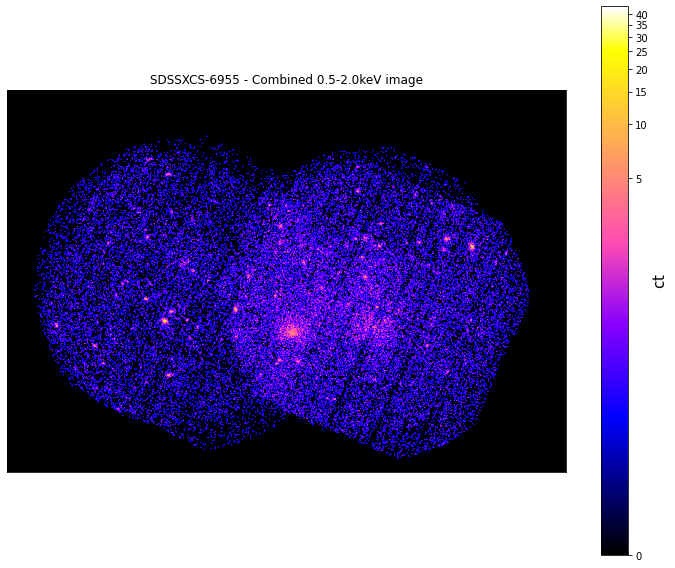

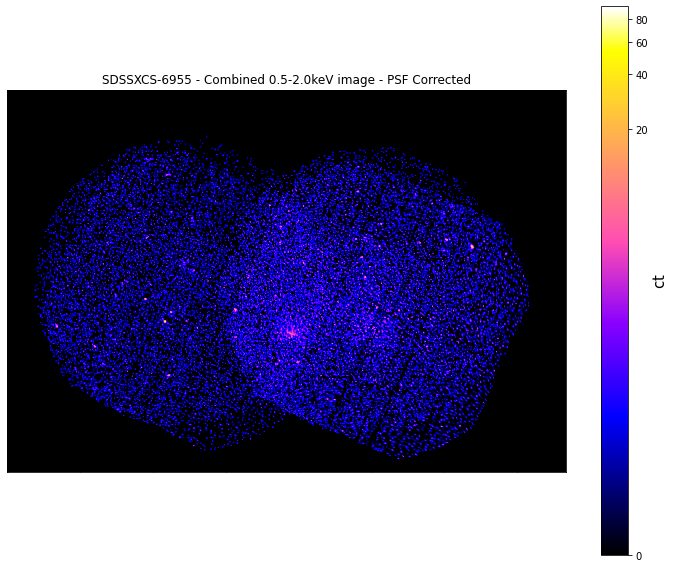


-----------------------------------------------------
Source Name - SDSSXCS-6955
User Coordinates - (36.45483, -5.894147599999998) degrees
X-ray Peak - (36.45483, -5.894147599999998) degrees
nH - 0.0249 1e+22 / cm2
Redshift - 0.223
XMM ObsIDs - 2
PN Observations - 2
MOS1 Observations - 2
MOS2 Observations - 2
On-Axis - 0
With regions - 2
Total regions - 61
Obs with 1 detection - 2
Obs with >1 matches - 0
Images associated - 36
Exposure maps associated - 18
Combined Ratemaps associated - 5
Spectra associated - 24
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 668.9936764375799 kpc
R500 SNR - 41.3
R2500 - 321.8889306664823 kpc
R2500 SNR - 27.21
Richness - 32.131187±2.8320866
R500 Tx - 2.18±0.305[keV]
R500 0.5-2.0keV Lx - 0.25±0.025[e+44 erg/s]
-----------------------------------------------------



In [10]:
for src in examp_srcs:
    src.get_combined_images(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV')).view()
    src.get_combined_images(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'), psf_corr=True).view()
    src.info()

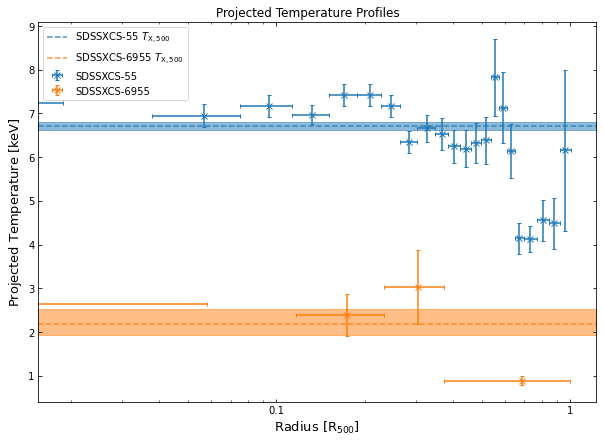

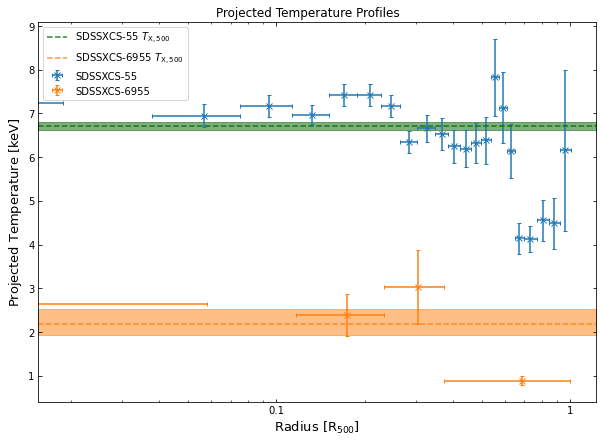

In [11]:
t500_unit = def_unit('t500', format={'latex': r"\mathrm{T_{X,500}}"})
tp_one = examp_srcs[0].get_proj_temp_profiles()
tp_one.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
t_one = examp_srcs[0].get_temperature('r500')
tp_one.y_norm = t_one[0] / Quantity(1, t500_unit)

tp_two = examp_srcs[1].get_proj_temp_profiles()
tp_two.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)
t_two = examp_srcs[1].get_temperature('r500')
tp_two.y_norm = t_two[0] / Quantity(1, t500_unit)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}

(tp_one + tp_two).view(x_norm=True, y_norm=False, draw_vals={r'SDSSXCS-55 $T_{\rm{X,500}}$': [t_one, 'tab:blue'], 
                                                             r'SDSSXCS-6955 $T_{\rm{X,500}}$': [t_two, 'tab:orange']},
                       yscale='linear', save_path="../outputs/figures/demo_clusters_projtemp.pdf", 
                       axis_formatters=forms)

(tp_one + tp_two).view(x_norm=True, y_norm=False, draw_vals={r'SDSSXCS-55 $T_{\rm{X,500}}$': [t_one, 'darkgreen'], 
                                                             r'SDSSXCS-6955 $T_{\rm{X,500}}$': [t_two, 'tab:orange']},
                       yscale='linear', save_path="../outputs/figures/demo_clusters_projtemp.pdf", 
                       axis_formatters=forms)

In [12]:
examp_srcs[0].obs_ids

['0149880101', '0303930101']

In [13]:
examp_srcs[1].obs_ids

['0677600131', '0404965201']

In [14]:
examp_srcs[1].matched_regions

{'0677600131': <EllipseSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
     (36.45719413, -5.8935039)>, width=0.04033076685274979 deg, height=0.036413375260336514 deg, angle=12.136122089608449 deg)>,
 '0404965201': <EllipseSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
     (36.45482991, -5.89414766)>, width=0.04467862927526675 deg, height=0.035625598999729544 deg, angle=-3.9225726364003193 deg)>}

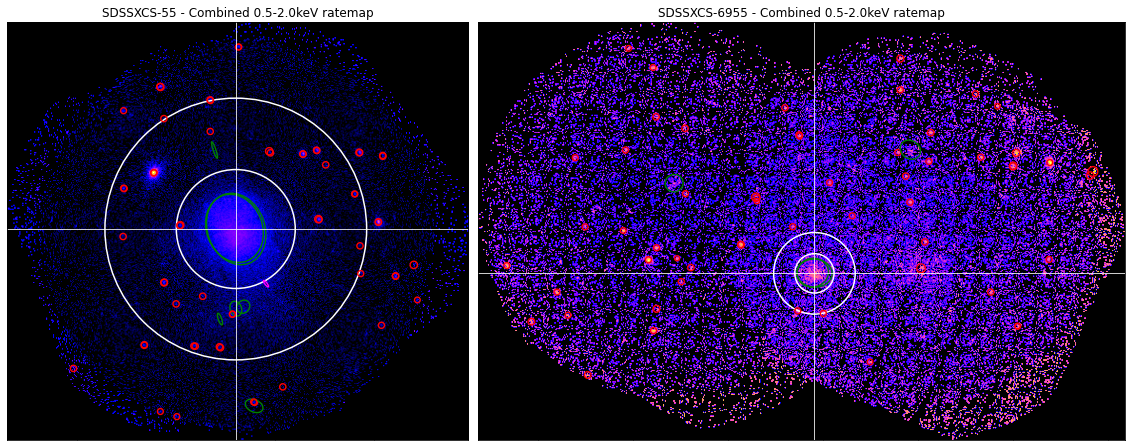

In [15]:
fig_size = (16.4, 5.8)
fig = plt.figure(figsize=fig_size)

rt_one = examp_srcs[0].get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

src_one_all_reg = {o: r + [examp_srcs[0].matched_regions[o]] 
                   for o, r in no_cust_reg_src.get_interloper_regions().items()}
rt_one.regions = src_one_all_reg

rt_two = examp_srcs[1].get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
src_two_all_reg = {o: r + [examp_srcs[1].matched_regions[o]] 
                   for o, r in examp_srcs[1].get_interloper_regions().items()}
rt_two.regions = src_two_all_reg

plt_buff = 1
tot_x = rt_one.shape[1] + rt_two.shape[1] + plt_buff

src_one_r500 = physical_rad_to_pix(rt_one, examp_srcs[0].r500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, 
                                   xcs_cosmo).value
src_one_r2500 = physical_rad_to_pix(rt_one, examp_srcs[0].r2500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, 
                                    xcs_cosmo).value
src_two_r500 = physical_rad_to_pix(rt_two, examp_srcs[1].r500, examp_srcs[1].ra_dec, examp_srcs[1].redshift, 
                                   xcs_cosmo).value
src_two_r2500 = physical_rad_to_pix(rt_two, examp_srcs[1].r2500, examp_srcs[1].ra_dec, examp_srcs[1].redshift, 
                                    xcs_cosmo).value

rt_one_ax = fig.add_axes((0, 0, rt_one.shape[1]/tot_x, 1))
rt_one.get_view(rt_one_ax, examp_srcs[0].ra_dec, zoom_in=True, view_regions=True, 
                radial_bins_pix=[src_one_r2500, src_one_r500])

bodge_x = 30
rt_two_ax = fig.add_axes(((rt_one.shape[1] + plt_buff - bodge_x)/tot_x, 0, rt_two.shape[1]/tot_x, 1))
rt_two.get_view(rt_two_ax, examp_srcs[1].ra_dec, zoom_in=True, view_regions=True, 
                radial_bins_pix=[src_two_r2500, src_two_r500])

plt.savefig('../outputs/figures/demo_clusters_RT.pdf', bbox_inches='tight')
plt.show()

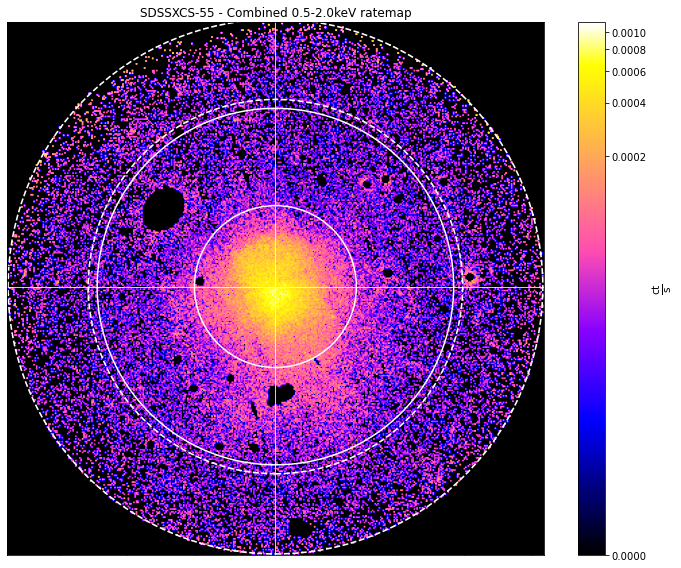

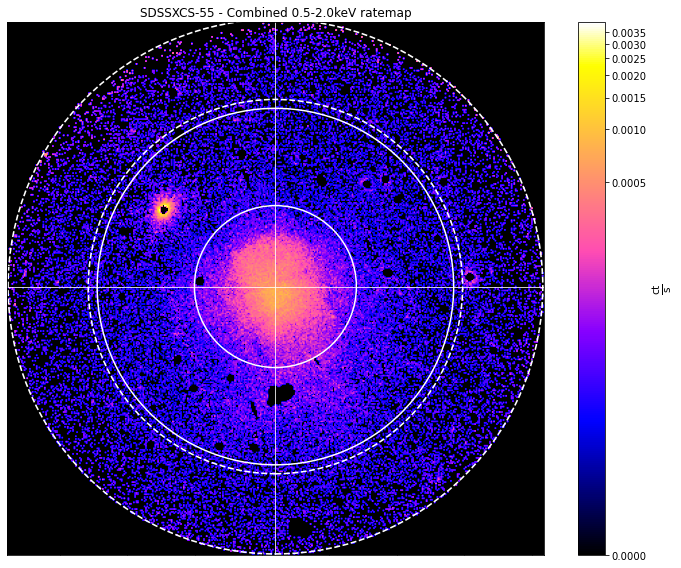

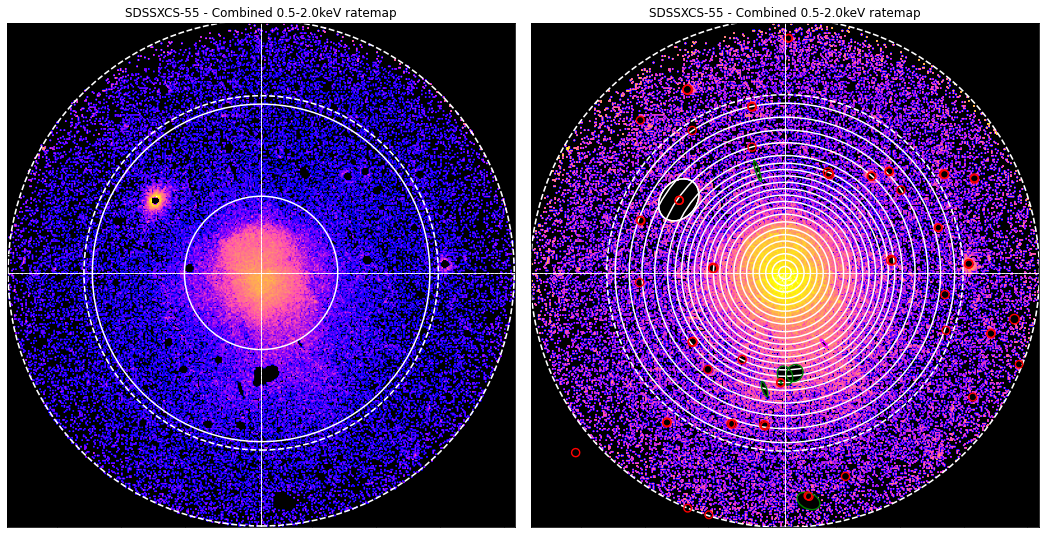

In [16]:
# rt_one.view(examp_srcs[0].ra_dec, examp_srcs[0].get_mask('r500')[0], zoom_in=True)
rt_one.view(examp_srcs[0].ra_dec, examp_srcs[0].get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
            radial_bins_pix=[src_one_r2500, src_one_r500], back_bin_pix=src_one_r500*np.array([1.05, 1.5]))
rt_one_no_cust = no_cust_reg_src.get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
rt_one_no_cust.view(examp_srcs[0].ra_dec, no_cust_reg_src.get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
            radial_bins_pix=[src_one_r2500, src_one_r500], back_bin_pix=src_one_r500*np.array([1.05, 1.5]))

fig = plt.figure(figsize=(15, 7))
no_cust_m_ax = fig.add_axes((0, 0, 0.5, 1))
rt_one_no_cust.get_view(no_cust_m_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                 no_cust_reg_src.get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
                 radial_bins_pix=[src_one_r2500, src_one_r500], back_bin_pix=src_one_r500*np.array([1.05, 1.5]))

cust_m_ax = fig.add_axes((0.485, 0, 0.5, 1))

pix_anns = physical_rad_to_pix(rt_one_no_cust, tp_one.annulus_bounds, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)
bck_anns = physical_rad_to_pix(rt_one_no_cust, tp_one.outer_radius, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)*np.array([1.05, 1.5])

rt_one.regions = examp_srcs[0].get_interloper_regions()
rt_one.get_view(cust_m_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                 examp_srcs[0].get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, view_regions=True,
                 radial_bins_pix=pix_anns.value, back_bin_pix=bck_anns.value)
# plt.tight_layout()
plt.savefig("../outputs/figures/demo_cluster_mask.pdf", bbox_inches='tight')
plt.show()

In [17]:
rl_psf(examp_srcs, bins=10)

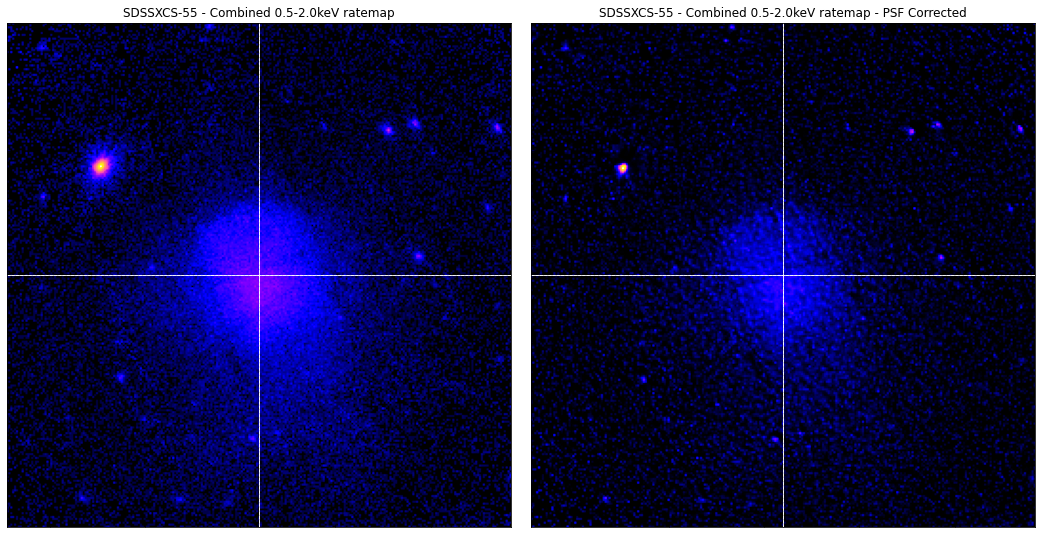

In [18]:
rt_one_psfc = examp_srcs[0].get_combined_ratemaps(psf_corr=True, psf_bins=10, lo_en=Quantity(0.5, 'keV'), 
                                                  hi_en=Quantity(2.0, 'keV'))

hh = physical_rad_to_pix(rt_one_psfc, examp_srcs[0].r500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, xcs_cosmo)
pix_coord = rt_one_psfc.coord_conv(examp_srcs[0].ra_dec, 'pix')
x_lims = Quantity([pix_coord[0]-hh, pix_coord[0]+hh]).value
y_lims = Quantity([pix_coord[1]-hh, pix_coord[1]+hh]).value

fig = plt.figure(figsize=(15, 7))
normal_ax = fig.add_axes((0, 0, 0.5, 1))
rt_one.get_view(normal_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), zoom_in=True, 
                manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)

psf_corr_ax = fig.add_axes((0.485, 0, 0.5, 1))
rt_one_psfc.get_view(psf_corr_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), zoom_in=True,
                 manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)
# plt.tight_layout()
# plt.savefig("../outputs/figures/demo_cluster_psfcorr.pdf", bbox_inches='tight')
plt.show()

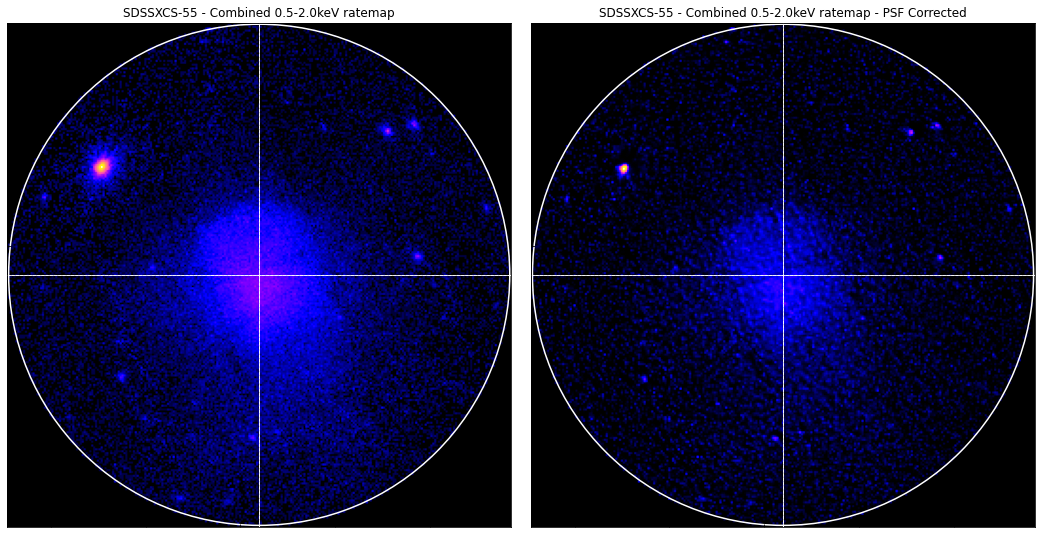

In [19]:
rt_one_psfc = examp_srcs[0].get_combined_ratemaps(psf_corr=True, psf_bins=10, lo_en=Quantity(0.5, 'keV'), 
                                                  hi_en=Quantity(2.0, 'keV'))

hh = physical_rad_to_pix(rt_one_psfc, examp_srcs[0].r500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, xcs_cosmo)
pix_coord = rt_one_psfc.coord_conv(examp_srcs[0].ra_dec, 'pix')
x_lims = Quantity([pix_coord[0]-hh, pix_coord[0]+hh]).value
y_lims = Quantity([pix_coord[1]-hh, pix_coord[1]+hh]).value

fig = plt.figure(figsize=(15, 7))
normal_ax = fig.add_axes((0, 0, 0.5, 1))
rt_one.get_view(normal_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                examp_srcs[0].get_custom_mask(examp_srcs[0].r500, remove_interlopers=False), zoom_in=True, 
                radial_bins_pix=[src_one_r500])

psf_corr_ax = fig.add_axes((0.485, 0, 0.5, 1))
rt_one_psfc.get_view(psf_corr_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                     examp_srcs[0].get_custom_mask(examp_srcs[0].r500, remove_interlopers=False), zoom_in=True, 
                     radial_bins_pix=[src_one_r500])
# plt.tight_layout()
plt.savefig("../outputs/figures/demo_cluster_psfcorr.pdf", bbox_inches='tight')
plt.show()

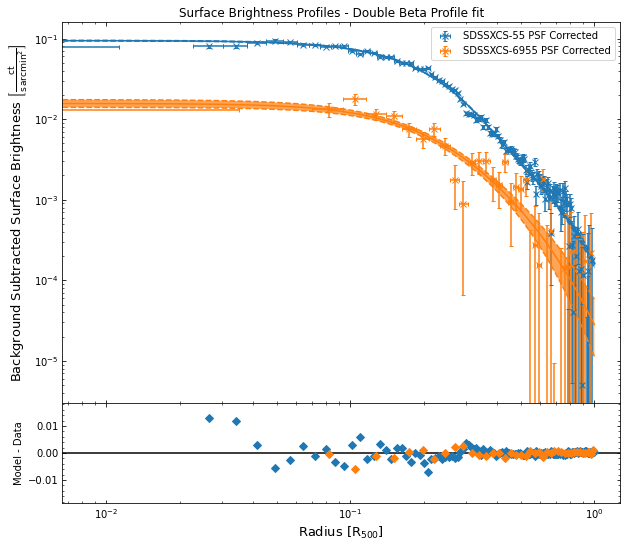

In [20]:
src_one_bp = examp_srcs[0].get_profiles('combined_brightness')[0]
src_one_bp.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
src_two_bp = examp_srcs[1].get_profiles('combined_brightness')[0]
src_two_bp.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)

(src_one_bp + src_two_bp).view(x_norm=True, model='double_beta', save_path='../outputs/figures/demo_clusters_sb.pdf')

In [21]:
# src_one_dp.generation_profile.get_model_fit('beta', 'mcmc').par_dist_view()

In [22]:
# sb_mod = src_one_dp.generation_profile.get_model_fit('double_beta', 'mcmc')
# sb_mod.par_dist_view()

/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


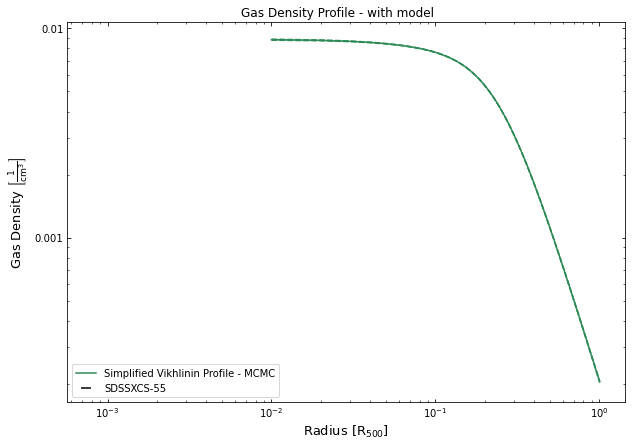

/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


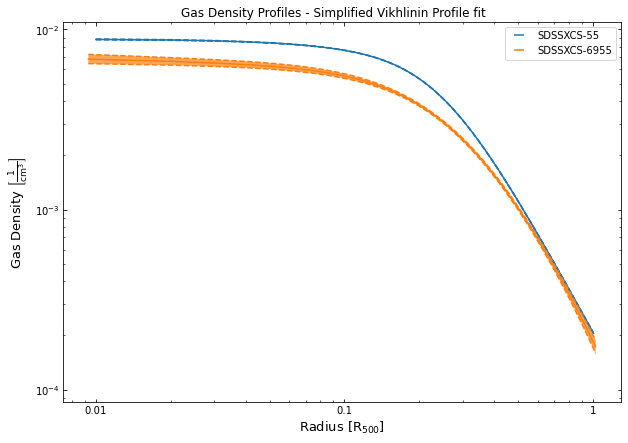

In [31]:
src_one_dp = examp_srcs[0].get_density_profiles()[0]
src_one_dp.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
src_one_dp.view(x_norm=True, just_models=True, show_residual_ax=False)
# src_one_dp.save_view('../outputs/figures/demo_clusters_dens.pdf', x_norm=True, just_models=True, 
#                      show_residual_ax=False)

src_two_dp = examp_srcs[1].get_density_profiles()
src_two_dp.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)


forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
(src_one_dp + src_two_dp).view(x_norm=True, model='simple_vikhlinin_dens', just_model=True, 
                               save_path='../outputs/figures/demo_clusters_dens.pdf', 
                               axis_formatters=forms, show_residual_ax=False)

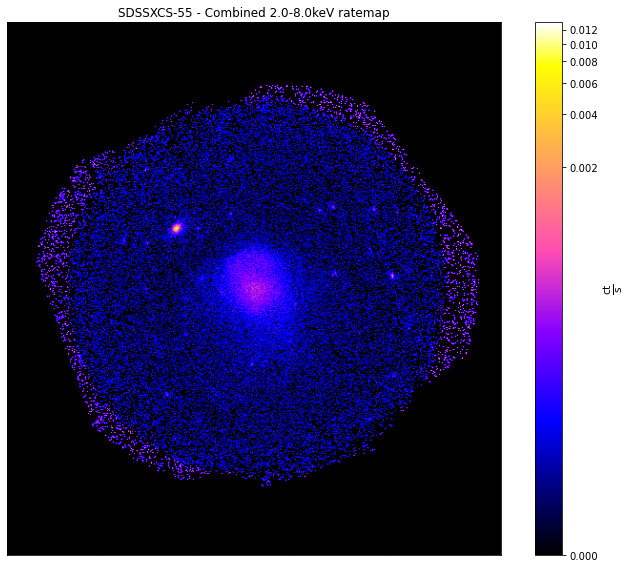

In [24]:
# emosaic(examp_srcs, 'image', Quantity(2.0, 'keV'), Quantity(8.0, 'keV'))
# emosaic(examp_srcs, 'expmap', Quantity(2.0, 'keV'), Quantity(8.0, 'keV'))
examp_srcs[0].get_combined_ratemaps(Quantity(2.0, 'keV'), Quantity(8.0, 'keV')).view()

In [25]:
# src_one_dp.gas_mass('simple_vikhlinin_dens', examp_srcs[0].r500)

In [26]:
# dps = inv_abel_fitted_model(examp_srcs, 'double_beta', outer_radius=examp_srcs.r500*1.01)

In [27]:
# dps[0].src_name = 'SDSSXCS-55'

In [28]:
# (dps[0]+src_one_dp).view()

In [29]:
# dps[0].fit('simple_vikhlinin_dens')
# dps[0].gas_mass('simple_vikhlinin_dens', examp_srcs[0].r500)

6.62246394e+13, 1.37141002e+11, 1.43774170e+11] solMass

[7.91776613e+13, 1.75464875e+11, 1.85142951e+11] solMass

In [30]:
stop

NameError: name 'stop' is not defined

In [ ]:
tp_one.outer_radius / examp_srcs[0].r500

In [ ]:
pix_anns = physical_rad_to_pix(rt_one_no_cust, tp_one.annulus_bounds, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)
rt_one.view(examp_srcs[0].ra_dec, examp_srcs[0].get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
            radial_bins_pix=pix_anns.value, back_bin_pix=src_one_r500*np.array([1.05, 1.5]), view_regions=False)

In [ ]:
examp_srcs[0].get_apec_norm_profiles().view(xscale='linear')
examp_srcs[0].get_apec_norm_profiles().emission_measure_profile(examp_srcs[0].redshift, 
                                                                examp_srcs[0].cosmo).view(xscale='linear')

In [ ]:
tp3d_one = examp_srcs[0].get_3d_temp_profiles()
tp3d_one.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
tp3d_one.view(xscale='linear')

tp3d_two = examp_srcs[1].get_3d_temp_profiles()
tp3d_two.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)
tp3d_two.view(xscale='linear')

In [ ]:
(tp3d_one + tp3d_two).view(model='simple_vikhlinin_temp', x_norm=True, 
                           save_path='../outputs/figures/demo_clusters_3dtemp.pdf')

In [ ]:
num_real = 10000

apec_norm_prof = examp_srcs[0].get_apec_norm_profiles()
proj_temp = examp_srcs[0].get_proj_temp_profiles()

# Also make an Emission Measure profile, used for weighting the contributions from different
#  shells to annuli
em_prof = apec_norm_prof.emission_measure_profile(examp_srcs[0].redshift, examp_srcs[0].cosmo, 'angr',
                                                  num_real, 1)
# src.update_products(em_prof)

cur_rads = proj_temp.annulus_bounds
# Need to make sure the annular boundaries are a) in a proper distance unit rather than degrees, and b)
#  in units of centimeters
cur_rads = examp_srcs[0].convert_radius(cur_rads, 'cm')

# Use a handy function I wrote to calculate the volume intersections of spherical shells and
#  projected annuli
vol_intersects = shell_ann_vol_intersect(cur_rads, cur_rads)

# Then it's an inverse matrix problem to recover the 3D temperatures
temp_3d = (np.linalg.inv(vol_intersects.T) @ (proj_temp.values * em_prof.values)) / (np.linalg.inv(
    vol_intersects.T) @ em_prof.values)

# I generate random realisations of the projected temperature profile and the emission measure profile
#  to help me with error propagation
proj_temp_reals = proj_temp.generate_data_realisations(num_real, truncate_zero=True)
em_reals = em_prof.generate_data_realisations(num_real, truncate_zero=True)

# Set up an N x R array for the random realisations of the 3D temperature, where N is22 the number
#  of realisations and R is the number of radius data points
temp_3d_reals = Quantity(np.zeros(proj_temp_reals.shape), proj_temp_reals.unit)
for i in range(0, num_real):
    # Calculate and store the 3D temperature profile realisations
    interim = (np.linalg.inv(vol_intersects.T) @ (proj_temp_reals[i, :] * em_reals[i, :])) / (np.linalg.inv(
        vol_intersects.T) @ em_reals[i, :])
    temp_3d_reals[i, :] = interim

# Calculate a standard deviation for each bin to use as the uncertainty
temp_3d_sigma = np.std(temp_3d_reals, axis=0) * 1
print(temp_3d_sigma)
meddo = np.percentile(temp_3d_reals, 50, axis=0)
# temp_3d_sigma = 
upper = np.percentile(temp_3d_reals, 84.1, axis=0)
lower = np.percentile(temp_3d_reals, 15.9, axis=0)

temp_3d_sigma = Quantity(np.average([meddo-lower, upper-meddo], axis=0), 'keV')
print(temp_3d_sigma.max())

# And finally actually set up a 3D temperature profile
temp_3d_prof = GasTemperature3D(proj_temp.radii, temp_3d, proj_temp.centre, proj_temp.src_name, '', '',
                                proj_temp.radii_err, temp_3d_sigma, proj_temp.set_ident,
                                proj_temp.associated_set_storage_key, proj_temp.deg_radii)

In [ ]:
em_prof.values

[8.8788389×1065, 2.4657492×1066, 3.5051941×1066, 4.218654×1066, 4.3558862×1066, 4.0679324×1066, 3.5533423×1066, 3.0876882×1066, 2.7106749×1066, 1.8031576×1066, 1.6392937×1066, 1.3901464×1066, 1.2579137×1066, 1.1224021×1066, 1.0704064×1066, 9.1677035×1065, 9.6988353×1065, 1.2314494×1066, 1.5940846×1066, 1.0941704×1066, 1.195449×1066, 7.6625552×1065]cm2cm5

In [ ]:
temp_3d

[9.3511571, 6.1517938, 7.8291867, 6.1316733, 7.5474896, 7.7128579, 8.6267035, 5.9868031, 6.8546284, 7.1116085, 6.3947824, 5.704497, 6.8000125, 2.5968047, 10.109687, 11.192072, 15.602915, 4.2167505, 3.6250735, 5.3480357, 3.0384646, 6.15485]keV

In [ ]:
tp_one.view()
temp_3d_prof.fit('simple_vikhlinin_temp')
temp_3d_prof.view()

In [ ]:
temp_3d_prof.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
(temp_3d_prof+tp3d_two).view(model='simple_vikhlinin_temp', x_norm=True, yscale='log',
                           save_path='../outputs/figures/demo_clusters_3dtemp.pdf')


In [ ]:
src_one_dp.view()

In [ ]:
temp_3d_prof.view()

In [ ]:
temp_model.derivative(Quantity(100, 'kpc'))*temp_model.

In [ ]:
temp_3d_reals.min()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(temp_3d_reals[:, 0].value, bins='auto')
plt.show()

In [ ]:
em_prof.view()

In [ ]:
from scipy.stats import truncnorm
loc = tp_one.values.value
scale = tp_one.values_err.value

lims = ((0 - loc) / scale, (np.inf - loc) / scale)
print(lims)

# Here I copy the values and value uncertainties N times, where N is the number of realisations
#  the user wants
ext_values = np.repeat(tp_one.values[..., None], 10000, axis=1).T
ext_value_errs = np.repeat(tp_one.values_err[..., None], 10000, axis=1).T

# Then I just generate N realisations of the profiles using a normal distribution, though this does assume
#  that the errors are one sigma which isn't necessarily true
# realisations = np.random.normal(ext_values, ext_value_errs)
testo = truncnorm(lims[0], lims[1], loc=loc, scale=scale).rvs([10000, 22])
print(testo.shape)
plt.hist(testo[:, -2])

# realisations = Quantity(realisations, self.values_unit)

# dir(truncnorm(0, np.inf, loc=1, scale=0.4))

In [ ]:
(temp_3d_prof+tp3d_one).view(xscale='linear')

In [ ]:
(temp_3d_reals[:, -7] > 0).sum()

In [ ]:
plt.hist(temp_3d_reals[:, -7].value)

In [ ]:
temp_3d_reals[:, -7].value.max()

In [ ]:
temp_3d_reals[:, -7].value.std()

In [ ]:
np.percentile(temp_3d_reals[:, -7].value, 84.1) - np.percentile(temp_3d_reals[:, -7].value, 50)

In [ ]:
np.percentile(temp_3d_reals[:, -7].value, 50) - np.percentile(temp_3d_reals[:, -7].value, 15.9)

In [ ]:
len(examp_srcs[0].get_annular_spectra(set_id=tp3d_one.set_ident).all_spectra)

In [ ]:
len(examp_srcs[1].get_annular_spectra(set_id=tp3d_two.set_ident).all_spectra)

In [ ]:
examp_srcs[0].info()

In [ ]:
examp_srcs[0].get_hydrostatic_mass_profiles()

In [ ]:
import json
with open('../data_notes/obs_info.json', 'r') as reado:
    obso = json.load(reado)
    
print(len(obso))

In [ ]:
len(set(list(obso.keys())))

In [ ]:
raddoo = temp_3d_prof.radii
raddoo[0] = Quantity(20, 'kpc')

In [ ]:
hym = HydrostaticMass(temp_3d_prof, 'simple_vikhlinin_temp', src_one_dp, 'simple_vikhlinin_dens', 
                      raddoo, temp_3d_prof.radii_err, temp_3d_prof.deg_radii)

In [ ]:
from xga import NHC, ABUND_TABLES, MEAN_MOL_WEIGHT
from astropy.constants import k_B, G, m_p

radius = raddoo

upper = 50 + (68.2 / 2)
lower = 50 - (68.2 / 2)

already_run = False

dens_model = src_one_dp.get_model_fit('simple_vikhlinin_dens', 'mcmc')
temp_model = temp_3d_prof.get_model_fit('simple_vikhlinin_temp', 'mcmc')

# If the models don't have analytical solutions to their derivative then the derivative method will need
#  a dx to assume, so I will set one equal to radius/1e+6, should be small enough.
dx = radius/1e+6
if not already_run:
    # This grabs gas density values from the density model, need to check whether the model is in units
    #  of mass or number density
    if dens_model.y_unit.is_equivalent('1/cm^3'):
        dens = dens_model.get_realisations(radius)
        dens_der = dens_model.derivative(radius, dx, True)
    else:
        dens = dens_model.get_realisations(radius) / (MEAN_MOL_WEIGHT*m_p)
        dens_der = dens_model.derivative(radius, dx, True) / (MEAN_MOL_WEIGHT*m_p)

    # We do the same for the temperature vals, again need to check the units
    if temp_model.y_unit.is_equivalent("keV"):
        temp = (temp_model.get_realisations(radius)/k_B).to('K')
        temp_der = temp_model.derivative(radius, dx, True)/k_B
        temp_der = temp_der.to(Unit('K')/temp_model.x_unit)
    else:
        temp = temp_model.get_realisations(radius).to('K')
        temp_der = temp_model.derivative(radius, dx, True).to('K')

    # Please note that this is just the vanilla hydrostatic mass equation, but not written in the "standard
    #  form". Here there are no logs in the derivatives, because it's easier to take advantage of astropy's
    #  quantities that way.
    mass_dist = ((-1 * k_B * np.power(radius[..., None], 2)) / (dens * (MEAN_MOL_WEIGHT*m_p) * G)) * \
                ((dens * temp_der) + (temp * dens_der))

    # Just converts the mass/masses to the unit we normally use for them
    mass_dist = mass_dist.to('Msun').T

mass_med = np.percentile(mass_dist, 50, axis=0)
mass_lower = mass_med - np.percentile(mass_dist, lower, axis=0)
mass_upper = np.percentile(mass_dist, upper, axis=0) - mass_med

mass_res = Quantity(np.array([mass_med.value, mass_lower.value, mass_upper.value]), mass_dist.unit)

print(mass_res)

if np.any(mass_res[0] < 0):
    # raise ValueError("A mass of less than zero has been measured, which is not physical.")
    print('CURRENT BODGE')

    print(len(mass_res[0]), (mass_res[0] < 0).sum())

In [ ]:
plt.hist(mass_dist[:, 2].value, bins='auto')
plt.show()

In [ ]:
examp_srcs[0].r500*0.15

In [ ]:
hym.radii

In [ ]:
hym.mass(examp_srcs[0].r500)

[5.16036032e+14 5.78980944e+13 5.79106213e+13] solMass

In [ ]:
hym.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
hym.view(x_norm=True)
hym.save_view('../outputs/figures/demo_clusters_hym.pdf', x_norm=True)

In [ ]:
import json

with open('../data_notes/obs_info.json', 'r') as whicho:
    used_obs = json.load(whicho)

In [ ]:
len([o for o in used_obs if len([ns for ns in used_obs[o] if 'SDSSXCS-' in ns])])

In [ ]:
len([o for o in used_obs if len([ns for ns in used_obs[o] if 'XLSSC' in ns])])